In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
Blackbox Attack

The blackbox attack works as follows:
Since we do not know details about the model we are attacking, we train a "substitute model" to approximate the "target model".
This is done using a small sample of training data, labeled by the target model (aka the oracle) instead of using the true labels. 
This way, the substitute learns to mimic the target model.
In addition, we augment this training data using "Jacobian-based data augmentation" (TODO)
Finally, we use one of the regular attacks on the substitute model. Supposedly, an attack that works well against the substitute
will also work well against the target. 
"""

'\nBlackbox Attack\n\nThe blackbox attack works as follows:\nSince we do not know details about the model we are attacking, we train a "substitute model" to approximate the "target model".\nThis is done using a small sample of training data, labeled by the target model (aka the oracle) instead of using the true labels. \nThis way, the substitute learns to mimic the target model.\nIn addition, we augment this training data using "Jacobian-based data augmentation" (TODO)\nFinally, we use one of the regular attacks on the substitute model. Supposedly, an attack that works well against the substitute\nwill also work well against the target. \n'

In [3]:
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image 
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
from torch.autograd.functional import jacobian
from torch.autograd import grad
from sklearn.model_selection import train_test_split

import team36
from team36.mnist.data_loading import MNIST_Loader
from team36.mnist.vgg import VGG
from team36.mnist.cnn import CNN
from team36.attacks.fast_gradient_attack_data_set import FastSignGradientAttackDataSet
from team36.training import train, validate, accuracy, predict, predict_from_loader, do_training, load_or_train, train_val_split

DIR = '.'
DATA_DIR = f'{DIR}/data'

In [4]:
"""
Step 1
Train the target model (aka the Oracle) or load from a checkpoint
"""

'\nStep 1\nTrain the target model (aka the Oracle) or load from a checkpoint\n'

In [5]:
"""
Set up the datasets
It is interesting to compare using the same dataset for the substitute and oracle vs. using different datasets
"""
ORACLE_DATASET = 'CIFAR10' # 'MNIST' or 'CIFAR10'
SUB_DATASET = 'CIFAR10' 
DATASET_NAMES = [ORACLE_DATASET, SUB_DATASET]
MODEL_NAMES = ['oracle', 'sub']
ORACLE = 0
SUB = 1
datasets = [] # two-element list to store the oracle dataset and the substitute dataset
dataset_image_sizes = []
dataset_channels = []
test_datasets = []

# class Grayscale_to_RGB(object):
#     def __call__(self, sample):
#         print(sample)
#         return sample

# def grayscale_to_rgb(sample):
#     print(sample)
#     return sample
# #     return sample.repeat(1, 3, 1, 1)

for idx, dataset_name in enumerate(DATASET_NAMES):
    transform_seq = [transforms.ToTensor()]
    if dataset_name == 'MNIST':
        image_size = 28
        in_channels = 1
        if idx == SUB and ORACLE_DATASET != 'MNIST': # if substitute uses mnist, but oracle uses other dataset add padding to match image size
            padding = (dataset_image_sizes[ORACLE] - image_size) // 2
            transform_seq.append(transforms.Pad(padding, fill=0))
            image_size += padding * 2
#             transform_seq.append(transforms.Lambda(lambda x: x))
            transform_seq.append(transforms.Lambda(lambda x: x.repeat(3, 1, 1)))
            in_channels = 3 # also need to copy to 3 channels to match rgb cifar
            # NOTE: above assumes oracle_dataset has larger images and that there is an even number difference in the image sizes
        dataset = torchvision.datasets.MNIST(root=DATA_DIR, train=True, download=True, 
                                              transform=transforms.Compose(transform_seq))
        test_dataset = torchvision.datasets.MNIST(root=DATA_DIR, train=False, download=True, 
                                              transform=transforms.Compose(transform_seq))
#         if idx == SUB and ORACLE_DATASET != 'MNIST':
#             # also need to copy to image to 3 channels to match rgb cifar
# #             transform_seq.append(grayscale_to_rgb) # copy single channel to 3 channels (from https://discuss.pytorch.org/t/grayscale-to-rgb-transform/18315)
#             dataset.data = dataset.data.unsqueeze(1).repeat(1, 3, 1, 1)            
#             in_channels = 3
    elif dataset_name == 'CIFAR10':
        image_size = 32
        in_channels = 3
        dataset = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True,
                                                transform=transforms.Compose(transform_seq))
        test_dataset = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, 
                                              transform=transforms.Compose(transform_seq))
    datasets.append(dataset)
    dataset_image_sizes.append(image_size)
    dataset_channels.append(in_channels)
    test_datasets.append(test_dataset)

datasets

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


[Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
            ),
 Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
            )]

In [6]:
%%time
image_size = dataset_image_sizes[ORACLE]
in_channels = dataset_channels[ORACLE]
oracle = VGG(image_size=image_size, in_channels=in_channels) # set the target model here
oracle_checkpoint = f'{DATASET_NAMES[ORACLE]}-vgg.pth' # e.g. 'MNIST-vgg.pth'
# oracle_checkpoint = 'mnist-vgg.pth'
oracle_checkpoint = oracle_checkpoint.lower()

learning_rate = 5e-4
momentum = 5e-1
# momentum = .9
weight_decay = 1e-1
batch_size = 32
epochs = 10

load_or_train(oracle, oracle_checkpoint, dataset=datasets[ORACLE], epochs=epochs, learning_rate=learning_rate, 
              weight_decay=weight_decay, momentum=momentum, batch_size=batch_size,
             optim=torch.optim.SGD)
# hyperparam tuning notes: 
# small learning rate is good for VGG on CIFAR (0.001 better than 0.01 and much better than 0.1)

# if os.path.exists(oracle_checkpoint_path): # if trained checkpoint exists, load it
#     state_dict = torch.load(f"{DIR}/checkpoints/{checkpoint}", map_location=torch.device('cpu'))
#     model.load_state_dict(state_dict)
# else: # else, train the model
# training_indices, validation_indices, _, _ = train_test_split(
#     range(len(target_data)),
#     target_data.targets,
#     stratify=target_data.targets,
#     test_size=0.1,
# )
# oracle_train_split = torch.utils.data.Subset(target_data, training_indices)
# oracle_val_split = torch.utils.data.Subset(target_data, validation_indices)
# print(f"{len(oracle_train_split)} in training set")
# print(f"{len(oracle_val_split)} in validation set")

# do_training(oracle, training_split=oracle_train_split, validation_split=oracle_val_split, epochs=EPOCHS)

Wall time: 17 ms


In [7]:
"""
Step 2
Train the substitute model on a small portion of the training data, using the oracle's predictions as the labels

oracle pred full mnist
replace targets
train val split (small train)
"""

"\nStep 2\nTrain the substitute model on a small portion of the training data, using the oracle's predictions as the labels\n\noracle pred full mnist\nreplace targets\ntrain val split (small train)\n"

In [8]:
sub = CNN(image_size = dataset_image_sizes[SUB], in_channels = dataset_channels[SUB])
sub_checkpoint = f'{DATASET_NAMES[SUB]}-substitute.pth' # e.g. 'MNIST-substitute.pth'

In [9]:
loader = torch.utils.data.DataLoader(datasets[SUB], batch_size=100, shuffle=False, num_workers=0)
# NOTE: due to a bug with lambda transforms on Windows, num_workers needs to be 0 or there will be an error
# https://github.com/belskikh/kekas/issues/26

In [10]:
datasets[SUB]

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [11]:
# datasets[SUB].data.shape

In [12]:
# for idx, (data, target) in enumerate(loader):
#         if torch.cuda.is_available():
#             data = data.cuda()
#             target = target.cuda()
#         print(data.shape)
# #         print(data.repeat(1, 3, 1, 1).shape)
#         print(target)
#         if idx > 1: break

In [13]:
%%time
oracle_preds = predict_from_loader(oracle, loader)

C:\Users\bkest\miniconda3\envs\cs7643-final-project-cpu\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0
C:\Users\bkest\miniconda3\envs\cs7643-final-project-cpu\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mo

Wall time: 2min 2s


In [14]:
oracle_preds = oracle_preds.argmax(axis=1)

In [15]:
len(oracle_preds[oracle_preds != datasets[SUB].targets]) # check oracle preds mostly matches true labels (if oracle was trained on same dataset)

1

In [16]:
datasets[SUB].targets = oracle_preds # replace true labels with oracle's predictions

In [17]:
train_size = 10000
train = Subset(datasets[SUB], range(train_size))
val = Subset(datasets[SUB], range(train_size, train_size*2)) # val split same size as train split
load_or_train(sub, sub_checkpoint, train_split=train, val_split=val, epochs=30)

In [18]:
"""
Step 3
Generate attack data for the substitute model and test both models with it
"""

'\nStep 3\nGenerate attack data for the substitute model and test both models with it\n'

In [19]:
target = oracle
criterion = nn.CrossEntropyLoss()
models = [oracle, sub]

In [20]:
test_datasets

[Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
            )]

In [21]:
"""Regular Test"""
# test_set = torchvision.datasets.MNIST(root=DATA_DIR, train=False, download=True, 
#                                       transform=transforms.ToTensor())
test_set = test_datasets[ORACLE] # since the substitute tries to mimic the oracle, we may as well test on the oracle's test set
for model, name in zip(models, MODEL_NAMES):
    print(name)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False, num_workers=0)

    test_accuracy, _, test_loss = validate(None, test_loader, model, criterion)

    print(f"{name} Regular Test Accuracy is {test_accuracy}")
    print(f"{name} Regular Test Loss is {test_loss}")

oracle
oracle Regular Test Accuracy is 0.7721999883651733
oracle Regular Test Loss is 0.7499974966049194
sub
sub Regular Test Accuracy is 0.2856000065803528
sub Regular Test Loss is 2.1041390895843506


In [22]:
%%time
"""Attack Test"""
test_set = test_datasets[ORACLE] # since the substitute tries to mimic the oracle, we may as well test on the oracle's test set
attack_test_set = FastSignGradientAttackDataSet(test_set, sub, criterion, epsilon=0.1)

for model, name in zip(models, MODEL_NAMES):
    print(name)
    test_loader = torch.utils.data.DataLoader(attack_test_set, batch_size=100, shuffle=False, num_workers=0)

    test_accuracy, _, test_loss = validate(None, test_loader, model, criterion)

    print(f"{name} Attack Test Accuracy is {test_accuracy}")
    print(f"{name} Attack Test Loss is {test_loss}")

oracle
oracle Attack Test Accuracy is 0.5281000137329102
oracle Attack Test Loss is 1.3595935106277466
sub
sub Attack Test Accuracy is 0.028999999165534973
sub Attack Test Loss is 2.677502155303955
Wall time: 55.7 s


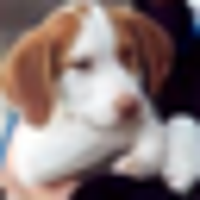

5
tensor([[0.0199, 0.0436, 0.1074, 0.1736, 0.0480, 0.3805, 0.0529, 0.0832, 0.0386,
         0.0522]], grad_fn=<SoftmaxBackward>)


C:\Users\bkest\Documents\OMSCS\Deep_Learning\project\omscs-dl-final-project\team36\training.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.softmax(out)


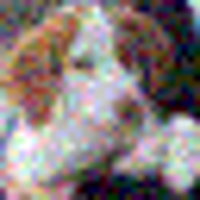

5
tensor([[0.0203, 0.0278, 0.1550, 0.1805, 0.1092, 0.2698, 0.0528, 0.0905, 0.0455,
         0.0485]], grad_fn=<SoftmaxBackward>)
True label 5


In [23]:
model = oracle
index = 16
# some clear images: 1=ship, 16=dog
disp_width, disp_height = 200, 200

input, _ = test_set[index]
img = transforms.functional.to_pil_image(input)
display(img.resize((disp_width, disp_height)))
print(predict(model, input, soft=False))
print(predict(model, input, soft=True))

input, _ = attack_test_set[index]
attack_img = transforms.functional.to_pil_image(input)
display(attack_img.resize((disp_width, disp_height)))
print(predict(model, input, soft=False))
print(predict(model, input, soft=True))

print('True label', test_set.targets[index])

# input, _ = attack_test_set[index]
# display(transforms.functional.to_pil_image(input))
# print(predict(defense_model, input))

# input, _ = attack_test_set[index]
# display(transforms.functional.to_pil_image(input))
# print(predict(fgsm_reg_defense_model, input))

In [ ]:
%%time
batch = iter(test_loader).next()[0]
J = jacobian(sub, batch)

In [ ]:
%%time
batch = iter(test_loader).next()[0]
J = jacobian(sub, batch[0].unsqueeze(0))

In [ ]:
J.squeeze().shape

In [ ]:
batch.shape

In [ ]:
J[0].shape

In [ ]:
J[0][0].shape

In [ ]:
iter(test_loader).next()[0].shape

In [ ]:
iter(test_loader).next()[0][0].shape

In [ ]:
(iter(test_loader).next()[0] + J).shape

In [ ]:
batch = iter(test_loader).next()[0]
sub(batch).shape

In [ ]:
modified_batch = batch + J
sub(modified_batch).shape

In [ ]:
(batch + J).shape

In [ ]:
(J + batch).shape

In [ ]:
torch.squeeze(J + batch).shape